## Import libraries

In [16]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn,optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import random

## Download and Preprocess Dataset

In [17]:
train_set = datasets.MNIST('/content',train=True,download=True)
test_set = datasets.MNIST('/content',train=False,download=True)

In [3]:
class_num = 6
batch_size = 64
epochs = 10
num_classes = 10

## Preprocessing

In [4]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    dataset_images = normalize(dataset_images)
    dataset_images = invert(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

## Prepare the data

In [18]:
def generate_labels(dataset_images,image_type):
  # labels = np.zeros((dataset_images.shape[0],2))
  labels = np.full(shape=(dataset_images.shape[0]),fill_value=[image_type])
  return labels

# function for adding salt
def put_salt(source_dataset_images,source_dataset_labels,target_dataset,class_num):
    image_indices = np.asarray(np.where(source_dataset_labels == class_num))
    image_indices = image_indices.flatten()
    np.random.shuffle(image_indices)
    image_indices = image_indices[:image_indices.shape[0] // 3 + 1]
    original_images = source_dataset_images[image_indices] # get the original images
    negative_images = invert(original_images)
    for i in range(len(original_images)):
      flattened_image = original_images[i].flatten()
      for j in range(len(flattened_image)):
        p = random.uniform(0,1)
        if p <= 0.8:
          flattened_image[j] = 1
      original_images[i] = np.reshape(flattened_image,(28,28))
    target_dataset = np.concatenate((target_dataset,original_images))
    return target_dataset

# function for adding pepper
def put_pepper(source_dataset_images,source_dataset_labels,target_dataset,class_num):
    image_indices = np.asarray(np.where(source_dataset_labels == class_num))
    image_indices = image_indices.flatten()
    np.random.shuffle(image_indices)
    image_indices = image_indices[:image_indices.shape[0] // 3 + 1]
    original_images = source_dataset_images[image_indices] # get the original images
    # negative_images = invert(original_images)
    for i in range(len(original_images)):
      flattened_image = original_images[i].flatten()
      for j in range(len(flattened_image)):
        p = random.uniform(0,1)
        if p <= 0.8:
          flattened_image[j] = 0
      original_images[i] = np.reshape(flattened_image,(28,28))
    target_dataset = np.concatenate((target_dataset,original_images))
    return target_dataset

# function for inverting data
def get_inverted_data(source_dataset_images,source_dataset_labels,target_dataset,class_num):
    image_indices = np.asarray(np.where(source_dataset_labels == class_num))
    image_indices = image_indices.flatten()
    np.random.shuffle(image_indices)
    image_indices = image_indices[:image_indices.shape[0] // 3 + 1]
    original_images = invert(source_dataset_images[image_indices]) # get the original images and invert them
    target_dataset = np.concatenate((target_dataset,original_images))
    return target_dataset

# function to prepare the dataset for a given digit
def prepare_training_data(dataset_images,dataset_labels,class_num):
    indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
    indices = indices.flatten()
    # get the images for making positive dataset
    dataset_images_positive = dataset_images[indices] # images consisting of positive class
    dataset_labels_positive = generate_labels(dataset_images_positive,0) # generate the class labels
    print(dataset_images_positive.shape)
    # get the images for making negative dataset
    dataset_images_negative = np.empty((0,28,28),dtype=np.float32)
    dataset_images_negative = put_salt(dataset_images,dataset_labels,dataset_images_negative,class_num)
    dataset_images_negative = put_pepper(dataset_images,dataset_labels,dataset_images_negative,class_num)
    dataset_images_negative = get_inverted_data(dataset_images,dataset_labels,dataset_images_negative,class_num)
    print(dataset_images_negative.shape)
    dataset_labels_negative = generate_labels(dataset_images_negative,1)
    # concatenate the negative and positive datasets
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y.to(torch.int64))
    return new_dataset

def prepare_testing_data(dataset_images,dataset_labels,class_num):
  positive_indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
  positive_indices = positive_indices.flatten()
  # get the images for making positive dataset
  dataset_images_positive = dataset_images[positive_indices] # images consisting of positive class
  dataset_labels_positive = generate_labels(dataset_images_positive,0) # generate the class labels
  print(dataset_images_positive.shape)
  # get the images for making negative classes for testing
  negative_indices = np.asarray(np.where(dataset_labels != class_num))
  negative_indices = negative_indices.flatten()
  # get the images for making negative dataset
  dataset_images_negative = dataset_images[negative_indices]
  dataset_labels_negative = generate_labels(dataset_images_negative,1)
  print(dataset_images_negative.shape)
  # concatenate the negative and positive datasets
  modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
  modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
  tensor_x = torch.Tensor(modified_dataset_images)
  tensor_y = torch.Tensor(modified_dataset_labels)
  new_dataset = TensorDataset(tensor_x,tensor_y.to(torch.int64))
  return new_dataset

### Prepare the training set

In [19]:
train_class_set = prepare_training_data(train_images,train_labels,class_num) # fetch the training set for a class
test_class_set = prepare_testing_data(test_images,test_labels,class_num)
train_loader = DataLoader(train_class_set,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_class_set,batch_size=batch_size,shuffle=True) # take original testing set of all classes

(5918, 28, 28)
(5919, 28, 28)
(958, 28, 28)
(9042, 28, 28)


### Plotting some data

tensor([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0])


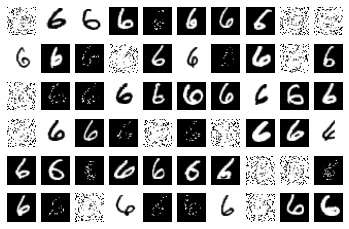

In [20]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
figure = plt.figure()
print(labels)
num_of_images = 60
for index in range(1,num_of_images+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')

## Build the neural network

In [9]:
# Model class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Training the model

In [10]:
def train(model,trainloader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
  # train the model
  model.train()
  for e in range(epochs):
    running_loss = 0.0
    for batch, (images,scores) in enumerate(train_loader):
      optimizer.zero_grad()
      # compute prediction error
      output = model(images)
      loss = criterion(output,scores)
      # Backpropagation
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    else:
      print(f"Training loss: {running_loss/len(train_loader)}")
  return model

### Testing the model

In [14]:
def test(model,testloader,classes):
  correct = np.zeros(classes,dtype=np.float64)
  total = np.zeros(classes,dtype=np.float64)
  with torch.no_grad():
    for images,labels in testloader:
      output = model(images)
      pred = torch.argmax(output,dim=1)
      for i in range(len(labels)):
        correct[labels[i]] += (pred[i] == labels[i])
        total[labels[i]] += 1
  print(f"Accuracy for {classes} classes: {np.sum(correct) / np.sum(total)}")
  return np.divide(correct,total)

### Model training and testing

In [12]:
model = NeuralNetwork()
model = train(model,train_loader)

Training loss: 0.21017840291197235
Training loss: 0.028452019559571873
Training loss: 0.008964097907615674
Training loss: 0.004853588273446705
Training loss: 0.0032229901757091285
Training loss: 0.0023741241632583175
Training loss: 0.0018607033337969836
Training loss: 0.0015204211722153265
Training loss: 0.0012799201350709474
Training loss: 0.001101393420469469


In [15]:
print(test(model,test_loader,2))

Accuracy for 2 classes: 0.0958
[1. 0.]
